<a href="https://colab.research.google.com/github/VIVEK-JADHAV/All-State-Claim-Severity/blob/master/AllStateClaimFeatureEngineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FEATURE ENGINEERING

### SVD Features

In [ ]:
#Normalizing the data

scaler = StandardScaler()
train_norm=scaler.fit_transform(X_train)
test_norm=scaler.transform(X_test)


In [ ]:
#Saving the model

file=open('/content/scalar.pkl','wb')
pickle.dump(scaler,file)
file.close()

In [ ]:
#Finding the number of eigen vectors that carry most of the info
s = np.linalg.svd(train_norm,compute_uv=False)
log_s=np.log(s)

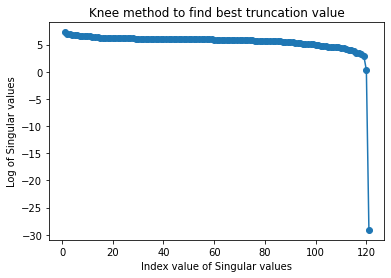

In [ ]:
#Plot to determine the best truncation value

index=[i for i in range(1,len(s)+1)]
plt.plot(index,log_s,marker='o')
plt.xlabel('Index value of Singular values')
plt.ylabel('Log of Singular values')
plt.title('Knee method to find best truncation value')
plt.show()

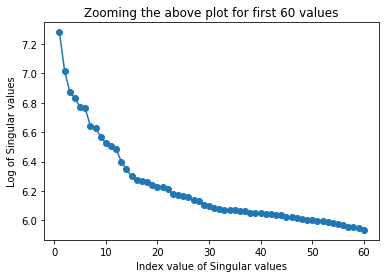

In [ ]:
plt.plot(index[0:60],log_s[0:60],marker='o')
plt.xlabel('Index value of Singular values')
plt.ylabel('Log of Singular values')
plt.title('Zooming the above plot for first 60 values')
plt.show()

In [ ]:
#Using Gavish-Donoho formula for optimal truncation value
sigma_median=np.median(s)
m=train_norm.shape[1]
n=train_norm.shape[0]
beta=m/n
lda=0.56*beta**3-0.95*beta**2+1.82*beta+1.43
threshold=lda*sigma_median
print(threshold)

539.1404054642065


In [ ]:
#Finding the rank of truncated SVD
new_s=s[s>=threshold]
rank=len(new_s)
print(rank)

15


In [ ]:
#Performing svd 
u,singular,vT = np.linalg.svd(train_norm,full_matrices=False)

In [ ]:
#Reducing the dimensions to rank 15
singular_diag=np.diagflat(singular)[:15,:15]
u=u[:,:15]
v=vT.T[:,:15]
svd_features_train=np.dot(u,singular_diag)
# svd_features_test=np.dot(test_norm,v)


In [ ]:
#Saving the v vector

file=open('/content/svd.pkl','wb')
pickle.dump(v,file)
file.close()

In [ ]:
#Saving the svd features with train data

svd_cols=['svd_'+str(i) for i in range(1,16)]
df_svd_train=pd.DataFrame(svd_features_train,columns=svd_cols).reset_index(drop=True)
train_svd=pd.concat([X_train,df_svd_train],axis=1)
train_svd['loss']=train['loss']
train_svd.to_csv('/content/train_svd.csv')
train_svd.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat16,cat17,cat18,cat19,cat20,cat21,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,svd_10,svd_11,svd_12,svd_13,svd_14,svd_15,loss
0,1,2,1,2,1,1,1,1,2,1,2,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,10,7,73,55,3,45,19,1,15,314,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,-3.587820,-2.334262,1.941901,-0.815969,-0.634624,2.430175,1.747016,-0.521169,-0.426067,0.854936,0.928602,0.906039,-1.977661,-0.171741,1.413094,2213.18
1,1,2,1,1,1,1,1,1,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,11,11,61,95,1,48,65,1,15,120,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,0.604131,-1.031821,0.282873,-3.564572,-1.292785,1.203978,-2.120771,1.650115,-0.281416,0.151048,0.789430,0.611068,1.998040,0.038470,-0.289677,1283.60
2,1,2,1,1,2,1,1,1,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,...,6,1,28,115,1,3,32,1,9,193,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,4.886900,-3.837837,-1.628231,1.098745,-2.875850,1.456246,0.373498,-1.011858,0.002318,-0.096218,1.951355,-1.092691,-1.512329,0.614697,-0.985298,3005.09
3,2,2,1,2,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,11,11,61,97,3,14,31,1,15,114,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,0.628367,-0.051739,1.705870,-2.788708,0.011725,1.961895,-1.820992,1.900531,-0.036486,0.972088,-0.385996,0.872351,-0.600374,0.571161,0.608295,939.85
4,1,2,1,2,1,1,1,1,2,2,1,2,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,7,2,8,3,3,25,65,1,11,89,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,6.147231,-3.085301,1.513916,-1.402452,-0.456628,1.051513,1.707206,-0.584438,-0.374283,0.126789,0.571433,-1.480711,-0.717282,-0.521213,0.851856,2763.85


In [ ]:
def createSVDFeatures(X):
  ''' Create SVD features '''
  X_copy=X.copy()
  file=open('/content/scalar.pkl','rb')
  scalar=pickle.load(file)
  file.close()
  X_copy=scalar.transform(X_copy)

  file=open('/content/svd.pkl','rb')
  v=pickle.load(file)
  file.close()
  
  svd_features=np.dot(X_copy,v)

  svd_cols=['svd_'+str(i) for i in range(1,16)]
  df_svd=pd.DataFrame(svd_features,columns=svd_cols)  

  return df_svd

In [ ]:
#Adding svd features to test data
te_svd=createSVDFeatures(X_test)
test_svd=pd.concat([X_test,te_svd],axis=1)
test_svd.to_csv('/content/test_svd.csv')
test_svd.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat16,cat17,cat18,cat19,cat20,cat21,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,...,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,svd_10,svd_11,svd_12,svd_13,svd_14,svd_15
0,1,2,1,1,1,1,1,1,2,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,9,12,11,61,55,1,10,50,1,17,215,0.321594,0.299102,0.246911,0.402922,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562,-0.541716,-1.298529,0.579290,-3.849314,-1.166997,1.697714,-0.665472,1.122065,-0.542094,0.368912,1.022336,1.046477,-1.387140,-0.279410,0.316355
1,1,2,1,2,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,7,6,2,61,93,5,7,24,1,12,219,0.634734,0.620805,0.654310,0.946616,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045,-0.126888,-1.229528,2.424850,3.017369,0.267554,1.508161,0.122733,-0.258234,0.415764,0.579032,0.984017,0.120472,1.429014,-1.049159,2.525470
2,1,2,1,2,2,1,2,1,2,2,1,2,2,2,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,2,1,2,2,1,1,1,...,10,7,1,61,97,3,21,31,1,11,89,0.290813,0.737068,0.711159,0.412789,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232,5.765240,-6.722534,-2.692070,0.618805,2.822154,-1.063586,-5.366465,-7.231823,-5.897545,-2.079147,-0.616414,-0.697785,-0.168696,5.008780,-0.967316
3,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,2,1,1,2,1,...,9,11,11,61,96,1,51,36,1,16,114,0.268622,0.681761,0.592681,0.354893,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955,0.815822,-1.175905,-3.666285,-3.206789,3.114373,-0.280647,-1.568515,2.028979,0.445841,0.036067,-1.639332,-3.517516,-0.902045,-1.593482,-1.611711
4,2,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,7,5,2,28,137,1,5,9,3,10,209,0.553846,0.299102,0.263570,0.696873,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823,1.233508,2.724110,0.035449,1.007137,-1.340573,0.142148,2.787295,-1.481567,-0.683963,0.482587,-0.269144,1.444558,-0.782961,-0.827569,0.118698


### Distance Features

In [ ]:
def distance(centroid,data):
  '''Returns distance of each point from centroid'''
  d=[]
  for i in data:
    l=np.dot((centroid-i),(centroid-i).T)[0][0]    
    dist=np.sqrt(l)    
    d.append(dist)
  return d

In [ ]:
#Finding centroid of Binary features

binary_train=train_norm[:,0:63]
kmeans = KMeans(n_clusters=1, random_state=0).fit(binary_train)
binary_centroid=kmeans.cluster_centers_


In [ ]:
#Saving the binary_centroid

file=open('/content/binary_centroid.pkl','wb')
pickle.dump(binary_centroid,file)
file.close()

In [ ]:
#Finding distance between centroid and each datapoint

binary_train_features=distance(binary_centroid,train_norm[:,0:63])

In [ ]:
#Finding centroid of Multilevel features

multilevel_train=train_norm[:,63:107]
kmeans = KMeans(n_clusters=1, random_state=0).fit(multilevel_train)
multilevel_centroid=kmeans.cluster_centers_

In [ ]:
#Saving the multilevel_centroid

file=open('/content/multilevel_centroid.pkl','wb')
pickle.dump(multilevel_centroid,file)
file.close()

In [ ]:
#Finding distance between centroid and each datapoint

multilevel_train_features=distance(multilevel_centroid,train_norm[:,63:107])

In [ ]:
#Finding centroid of Numerical features
numerical_train=train_norm[:,107:121]
kmeans = KMeans(n_clusters=1, random_state=0).fit(numerical_train)
numerical_centroid=kmeans.cluster_centers_

In [ ]:
#Saving the numerical_centroid

file=open('/content/numerical_centroid.pkl','wb')
pickle.dump(numerical_centroid,file)
file.close()

In [ ]:
#Finding distance between centroid and each datapoint

numerical_train_features=distance(numerical_centroid,train_norm[:,107:121])

In [ ]:
#Creating a dataframe of train distance features

dist_train=pd.DataFrame(columns=['binary_dist','multi_dist','numerical_dist'])
dist_train['binary_dist']=binary_train_features
dist_train['multi_dist']=multilevel_train_features
dist_train['numerical_dist']=numerical_train_features

In [ ]:
#Reading csv with svd features and adding distance features(train)

# train_svd=pd.read_csv('/content/drive/My Drive/CaseStudy_1/CaseStudy1_files/train_svd.csv',index_col=0)
train_svd_dist=pd.concat([train_svd,dist_train],axis=1)
train_svd_dist.to_csv('/content/train_svd_dist.csv')
train_svd_dist.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat16,cat17,cat18,cat19,cat20,cat21,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,...,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,svd_10,svd_11,svd_12,svd_13,svd_14,svd_15,loss,binary_dist,multi_dist,numerical_dist
0,1,2,1,2,1,1,1,1,2,1,2,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,55,3,45,19,1,15,314,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,-3.587820,-2.334262,1.941901,-0.815969,-0.634624,2.430175,1.747016,-0.521169,-0.426067,0.854936,0.928602,0.906039,-1.977661,-0.171741,1.413094,2213.18,4.782652,6.197656,4.365217
1,1,2,1,1,1,1,1,1,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,95,1,48,65,1,15,120,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,0.604131,-1.031821,0.282873,-3.564572,-1.292785,1.203978,-2.120771,1.650115,-0.281416,0.151048,0.789430,0.611068,1.998040,0.038470,-0.289677,1283.60,3.685751,4.986822,3.041006
2,1,2,1,1,2,1,1,1,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,...,115,1,3,32,1,9,193,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,4.886900,-3.837837,-1.628231,1.098745,-2.875850,1.456246,0.373498,-1.011858,0.002318,-0.096218,1.951355,-1.092691,-1.512329,0.614697,-0.985298,3005.09,6.471628,6.970844,3.638453
3,2,2,1,2,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,97,3,14,31,1,15,114,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,0.628367,-0.051739,1.705870,-2.788708,0.011725,1.961895,-1.820992,1.900531,-0.036486,0.972088,-0.385996,0.872351,-0.600374,0.571161,0.608295,939.85,4.163597,5.328049,2.253826
4,1,2,1,2,1,1,1,1,2,2,1,2,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,3,3,25,65,1,11,89,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,6.147231,-3.085301,1.513916,-1.402452,-0.456628,1.051513,1.707206,-0.584438,-0.374283,0.126789,0.571433,-1.480711,-0.717282,-0.521213,0.851856,2763.85,5.166646,7.303207,4.537489


In [ ]:
#Create Distance features

def distance(centroid,data):
  '''Returns distance of each point from centroid'''
  d=[]
  for i in data:
    l=np.dot((centroid-i),(centroid-i).T)[0][0]    
    dist=np.sqrt(l)    
    d.append(dist)
  return d

def createDistanceFeatures(X):
  ''' Create distance features '''
  X_copy=X.copy()
  file=open('/content/scalar.pkl','rb')
  scalar=pickle.load(file)
  file.close()
  X_copy=scalar.transform(X_copy)

  file=open('/content/binary_centroid.pkl','rb')
  binary_centroid=pickle.load(file)
  file.close()

  file=open('/content/multilevel_centroid.pkl','rb')
  multilevel_centroid=pickle.load(file)
  file.close()

  file=open('/content/numerical_centroid.pkl','rb')
  numerical_centroid=pickle.load(file)
  file.close()

  binary_features=distance(binary_centroid,X_copy[:,0:63])
  multilevel_features=distance(multilevel_centroid,X_copy[:,63:107])
  numerical_features=distance(numerical_centroid,X_copy[:,107:121])

  dist=pd.DataFrame(columns=['binary_dist','multi_dist','numerical_dist'])
  dist['binary_dist']=binary_features
  dist['multi_dist']=multilevel_features
  dist['numerical_dist']=numerical_features

  return dist


In [ ]:
#Adding distance features to test data
te_dist=createDistanceFeatures(X_test)
test_svd_dist=pd.concat([test_svd,te_dist],axis=1)
test_svd_dist.to_csv('/content/test_svd_dist.csv')
test_svd_dist.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat16,cat17,cat18,cat19,cat20,cat21,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,...,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,svd_10,svd_11,svd_12,svd_13,svd_14,svd_15,binary_dist,multi_dist,numerical_dist
0,1,2,1,1,1,1,1,1,2,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,61,55,1,10,50,1,17,215,0.321594,0.299102,0.246911,0.402922,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562,-0.541716,-1.298529,0.579290,-3.849314,-1.166997,1.697714,-0.665472,1.122065,-0.542094,0.368912,1.022336,1.046477,-1.387140,-0.279410,0.316355,4.036598,4.656237,2.951203
1,1,2,1,2,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,61,93,5,7,24,1,12,219,0.634734,0.620805,0.654310,0.946616,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045,-0.126888,-1.229528,2.424850,3.017369,0.267554,1.508161,0.122733,-0.258234,0.415764,0.579032,0.984017,0.120472,1.429014,-1.049159,2.525470,6.663465,4.736061,3.731106
2,1,2,1,2,2,1,2,1,2,2,1,2,2,2,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,2,1,2,2,1,1,1,...,61,97,3,21,31,1,11,89,0.290813,0.737068,0.711159,0.412789,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232,5.765240,-6.722534,-2.692070,0.618805,2.822154,-1.063586,-5.366465,-7.231823,-5.897545,-2.079147,-0.616414,-0.697785,-0.168696,5.008780,-0.967316,16.412722,10.364548,3.865259
3,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,2,1,1,2,1,...,61,96,1,51,36,1,16,114,0.268622,0.681761,0.592681,0.354893,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955,0.815822,-1.175905,-3.666285,-3.206789,3.114373,-0.280647,-1.568515,2.028979,0.445841,0.036067,-1.639332,-3.517516,-0.902045,-1.593482,-1.611711,6.926959,7.528284,2.667634
4,2,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,28,137,1,5,9,3,10,209,0.553846,0.299102,0.263570,0.696873,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823,1.233508,2.724110,0.035449,1.007137,-1.340573,0.142148,2.787295,-1.481567,-0.683963,0.482587,-0.269144,1.444558,-0.782961,-0.827569,0.118698,3.689722,5.319539,3.189845
